**PROBLEM STATEMENT:**

I decided to treat this as a classification problem by creating a new binary 
variable affair (did the woman have at least one affair?) and trying to 
predict the classification for each woman.

**DATASET:**

The dataset I chose is the affairs dataset that comes with Statsmodels. It 
was derived from a survey of women in 1974 by Redbook magazine, in 
which married women were asked about their participation in extramarital 
affairs. More information about the study is available in a 1978 paper from 
the Journal of Political Economy. 
 
**DESCRIPTION OF VARIABLES**

The dataset contains 6366 observations of 9 variables: 
 
- rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good) 
 
- age: woman's age 
 
- yrs_married: number of years married 
 
- children: number of children 
 
- religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious) 
 
- educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree) 
 
- occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree) 
 
- occupation_husb: husband's occupation (same coding as above) 
 
- affairs: time spent in extra-marital affairs 


In [130]:
#Loading data and modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [131]:
#loading dataset - preprocessing
dta = sm.datasets.fair.load_pandas().data 

# Add "affair" column: 1 reprsents having affairs
dta['affair'] = (dta.affairs > 0).astype(int)

dta['affair']

0       1
1       1
2       1
3       1
4       1
       ..
6361    0
6362    0
6363    0
6364    0
6365    0
Name: affair, Length: 6366, dtype: int32

In [132]:
#Data Exploration - On average, Women who have affairs rate their marriages lower, which is to expected.
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [133]:
#Data Exploration - let check rate_marriage variable, which is also to expected.
dta.groupby('rate_marriage').mean()


,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


**Let visualized our Data**📊

Text(0, 0.5, 'Frequency')

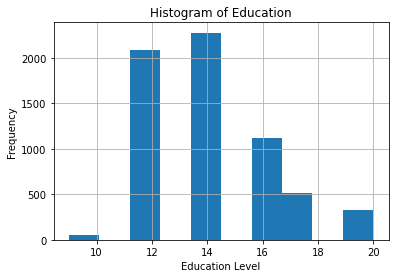

In [134]:
#Show plots in the notebook
%matplotlib inline

# Histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

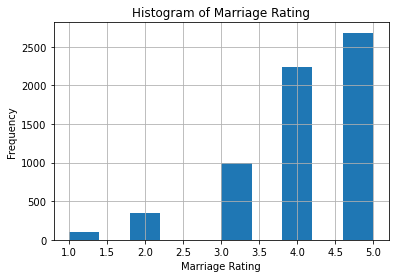

In [135]:
#Histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

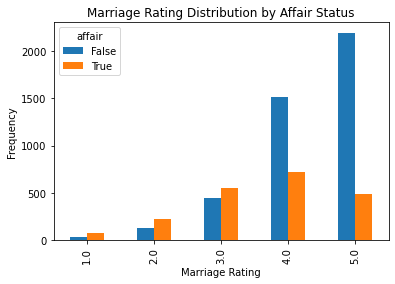

In [136]:
# Let check at the distribution of marriage ratings for those having affairs VS those not having affairs.
# barplot of marriage rating grouped by affair (True or False)♻

pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(0, 0.5, 'Percentage')

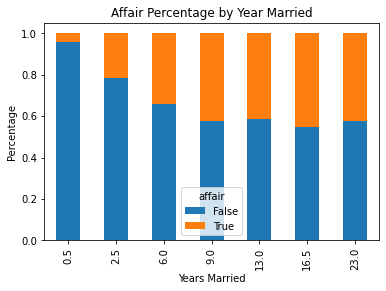

In [137]:
#Let also visualize the percentage of women having affairs by number of years of marriage.
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Year Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

**Preparing Data for Logistic Regression**📈



In [138]:
#Create DataFrame with an intercept column and dummy variables for occupation and occupation_husb. 
#Let treating them as categorical variables. 

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
print (X.columns)



Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [139]:
# Renaming column names for the dummy variables for better looks:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

# and flatten y into a 1-D array so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)
y

array([1., 1., 1., ..., 0., 0., 0.])

## Logistic Regression

In [140]:
#Let instantiate the Logistic Regression Model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# Let also check the accuracy on the training set
model.score(X, y)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7262016965127238

In [141]:
# We might be satisfy with 72% accuracy, but what percentage had affairs.
y.mean()

0.3224945020420987

In [142]:
#Now let examine our coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.4471268564107238]
1,occ_2,[0.12374027782178168]
2,occ_3,[0.3780205493573417]
3,occ_4,[0.09858660152660065]
4,occ_5,[0.7435180727302253]
5,occ_6,[0.3138796111066074]
6,occ_husb_2,[0.29491245514668996]
7,occ_husb_3,[0.4143856999681742]
8,occ_husb_4,[0.24858218926656978]
9,occ_husb_5,[0.2806847887789725]


## Model Evaluation Using a validation Set

In [143]:
# Evaluating the model by splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [144]:
# Evaluating the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

# predict class labels for the test set
predicted = model2.predict(X_test)
print("1- Predict Class Label for the Test Set:\n", predicted)

print("---------------------------------------------------------")

# generate class probabilities
probs = model2.predict_proba(X_test)
print ("2- Generating Class Probalities:\n", probs)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1- Predict Class Label for the Test Set:
 [1. 0. 0. ... 0. 0. 0.]
---------------------------------------------------------
2- Generating Class Probalities:
 [[0.35092243 0.64907757]
 [0.90276636 0.09723364]
 [0.72125665 0.27874335]
 ...
 [0.54966095 0.45033905]
 [0.8175006  0.1824994 ]
 [0.73858546 0.26141454]]


In [145]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [148]:
# Generating Evaluation Metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

0.7340314136125654
0.7465423221788269


✨The accuracy is 73%, which also result the same percentage as Training and Predicting on the same data.

In [149]:
#Let see the confusion matrix and classification report with other metrics.
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1173  130]
 [ 378  229]]
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      1303
         1.0       0.64      0.38      0.47       607

    accuracy                           0.73      1910
   macro avg       0.70      0.64      0.65      1910
weighted avg       0.72      0.73      0.71      1910



In [151]:
# Model Evaluation Using 10-fold Cross Validation to check the accuracy.
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

[0.72213501 0.70015699 0.73626374 0.70643642 0.71585557 0.72841444
 0.72641509 0.70754717 0.75471698 0.75157233]
0.7249513738732067


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


✨ The accuracy still perform at 73%.

In [152]:
# Let now predict the probabiliy of a random woman affair not included in our dataset. 
test_sample = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4, 16]).reshape(1, -1)
model.predict_proba(test_sample)

array([[0.77776942, 0.22223058]])

✨The predicted probability of having an affair is 23%